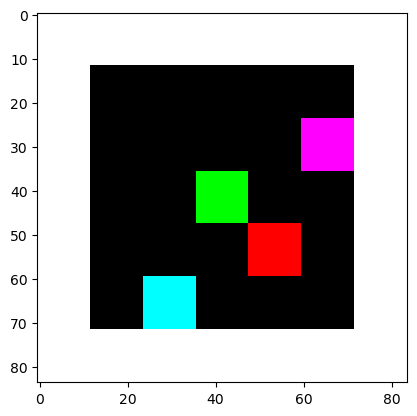

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from agent import *
from selection import *
from utils import *
from component.env import Environment, StochasticGameEnvironment
from simulation import *
from main import Config
from tqdm import tqdm
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import ticker

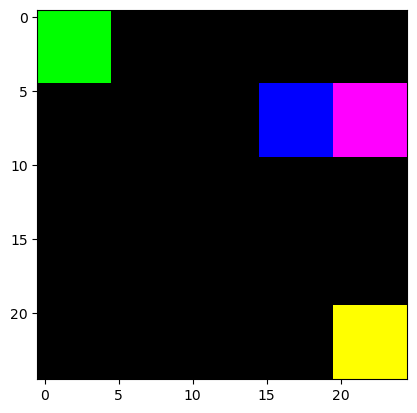

In [1]:
from component import Coins
env = Coins(size=5, config=None)


In [2]:
seed_everything()
config = {
    'reward': 3, 
    'sucker': 0, 
    'temptation': 5, 
    'punishment': 1, 
    'n_episodes': 10000, 
    'discount': 0.99,
    'play_epsilon': 1,
    'select_epsilon': 1,
    'epsilon_decay': 0.995,
    'min_epsilon': 0.01,
    'alpha': 0.1,
    'n_actions': 2,
    'h': 5,
    'select_h': 5,
    'state_repr': 'bi',
    'batch_size': 64,
    'learning_rate': 1e-3,
}
torch.cuda.is_available()

True

In [3]:
def check_convergence(agents: dict[int, object], thresh: tuple, k: int, last_reward: dict[int, float]):
    strategy_convergent_episode = {}
    reward_convergent_episode = {}
    thresh_strategy, thresh_reward = thresh[0], thresh[1]

    for n in agents:
        # Strategy convergence
        strategy_convergent = agents[n].determine_convergence(thresh_strategy, k)
        if strategy_convergent:
            strategy_convergent_episode[n] = agents[n].play_times

        # reward convergence
        if np.abs(agents[n].running_score-last_reward[n]) <= thresh_reward:
            reward_convergent_episode[n] = agents[n].play_times

    return strategy_convergent_episode, reward_convergent_episode

In [4]:
reward, temptation, sucker, punishment = generate_payoff_matrix('SH', N=100)
k = 1000
config['h'] = 5
config['n_episodes'] = 30000  # convergent threshold
config['epsilon_decay'] = 0.995
thresh_strategy = k * config['min_epsilon'] + 5
thresh_network = k/100
thresh_reward = 1
thresh = (thresh_strategy, thresh_reward, thresh_network)

In [6]:
df_episodic_sh = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                       'agent2_strategy', 'agent2_reward', 
                                       'agent3_strategy', 'agent3_reward', 
                                       'temptation', 'reward', 'punishment', 'sucker', 
                                       'agent1_final_strategy', 'agent1_defection_ratio',
                                       'agent2_final_strategy', 'agent2_defection_ratio',
                                       'agent3_final_strategy', 'agent3_defection_ratio',
                                       'agent1_updating_times', 'agent2_updating_times', 'agent3_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config['epsilon_decay'] = 0.995
    config['batch_size'] = 48
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.005, update_times=20, episodic_flag=True)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan


    df_episodic_sh.loc[len(df_episodic_sh.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                            float(torch.sum(agent3.own_memory)/agent3.play_times),
                                            sum(agents[0].updating_times.values()), sum(agents[1].updating_times.values()), sum(agents[2].updating_times.values())]

100it [4:02:16, 145.37s/it]


In [7]:
df_normal_sh = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'agent3_strategy', 'agent3_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent3_final_strategy', 'agent3_defection_ratio'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config['epsilon_decay'] = 0.995
    config['batch_size'] = 48
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthorityNormal(config_obj, agents, k, episodic_flag=False, settlement_prob=0.005, update_times=20)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan    


    df_normal_sh.loc[len(df_normal_sh.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                            float(torch.sum(agent3.own_memory)/agent3.play_times)]


2it [11:18, 339.30s/it]


KeyError: 2

In [8]:
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=20)
df_episodic_pd = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                       'agent2_strategy', 'agent2_reward', 
                                       'agent3_strategy', 'agent3_reward', 
                                       'temptation', 'reward', 'punishment', 'sucker', 
                                       'agent1_final_strategy', 'agent1_defection_ratio',
                                       'agent2_final_strategy', 'agent2_defection_ratio',
                                       'agent3_final_strategy', 'agent3_defection_ratio',
                                       'agent1_updating_times', 'agent2_updating_times', 'agent3_updating_times'])
for idx, val in tqdm(enumerate(reward)):
    config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
    config['epsilon_decay'] = 0.995
    config['batch_size'] = 48
    config_obj = Config(config)
    with HiddenPrints():
        env = Environment(config_obj)
        agent1 = construct_agent('LSTMQN', config_obj)
        agent2 = construct_agent('LSTMQN', config_obj)
        agent3 = construct_agent('LSTMQN', config_obj)
        
        agents = {}
        agents[0], agents[1], agents[2] = agent1, agent2, agent3 
        count = 0
        convergent_episode_dict = {'strategy':{}, 'reward':{}}
        select_dict = {}
        selected_dict = {}
        for n in agents:
            select_dict[n] = 0
            selected_dict[n] = 0
        authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.005, update_times=20, episodic_flag=True)

        while True:
            last_reward = {}
            for n in agents:
                last_reward[n] = agents[n].running_score
            
            select_dict, selected_dict = authority.run(select_dict, selected_dict)
            agents = authority.agents
            
            strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
            count += 1
            update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
            update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)
            
            print(convergent_episode_dict)
            
            if count*k >= config_obj.n_episodes:
                break

            converge = []
            for key, _ in convergent_episode_dict.items():
                converge.append(len(convergent_episode_dict[key]) == len(agents))
            if sum(converge) >= 2:
                break
    for key, v in convergent_episode_dict.items():
        if 0 not in list(v.keys()):
            convergent_episode_dict[key][0] = np.nan
        if 1 not in list(v.keys()):
            convergent_episode_dict[key][1] = np.nan
        if 2 not in list(v.keys()):
            convergent_episode_dict[key][2] = np.nan


    df_episodic_pd.loc[len(df_episodic_pd.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                            convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                            convergent_episode_dict['strategy'][2], convergent_episode_dict['reward'][2], 
                                            config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                            round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                            float(torch.sum(agent1.own_memory)/agent1.play_times),
                                            round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                            float(torch.sum(agent2.own_memory)/agent2.play_times),
                                            round(float(torch.sum(agent3.own_memory[agent3.play_times-100:agent3.play_times])/100)),
                                            float(torch.sum(agent3.own_memory)/agent3.play_times),
                                            sum(agents[0].updating_times.values()), sum(agents[1].updating_times.values()), sum(agents[2].updating_times.values())]


20it [48:51, 146.56s/it]


In [9]:
df_episodic_pd

,agent1_strategy,agent1_reward,agent2_strategy,agent2_reward,agent3_strategy,agent3_reward,temptation,reward,punishment,sucker,agent1_final_strategy,agent1_defection_ratio,agent2_final_strategy,agent2_defection_ratio,agent3_final_strategy,agent3_defection_ratio,agent1_updating_times,agent2_updating_times,agent3_updating_times
0,7232.0,12563.0,7139.0,12426.0,7009.0,11649.0,1.92,1.0,0.0,-0.63,1.0,0.935842,1.0,0.942137,1.0,0.946952,2000.0,1800.0,2000.0
1,NaN,28428.0,10808.0,NaN,16768.0,NaN,1.01,1.0,0.0,-0.06,1.0,0.828409,1.0,0.866557,1.0,0.895486,3540.0,1700.0,2200.0
2,19681.0,NaN,17809.0,20467.0,8202.0,10197.0,1.24,1.0,0.0,-0.28,0.0,0.590977,0.0,0.645948,1.0,0.901243,2980.0,2380.0,1520.0
3,7525.0,8515.0,15400.0,14739.0,7922.0,19104.0,1.39,1.0,0.0,-0.41,1.0,0.900059,1.0,0.930779,1.0,0.956524,1280.0,1940.0,2660.0
4,9648.0,22610.0,8078.0,9422.0,8662.0,14652.0,1.74,1.0,0.0,-0.85,1.0,0.930739,1.0,0.905328,1.0,0.947704,2600.0,1220.0,1740.0
5,13409.0,15409.0,8733.0,15434.0,7207.0,13206.0,2.40,1.0,0.0,-0.85,1.0,0.949770,1.0,0.950369,1.0,0.949918,2100.0,2100.0,2120.0
6,7472.0,7124.0,11133.0,15977.0,8420.0,13247.0,1.23,1.0,0.0,-0.94,1.0,0.903321,1.0,0.956929,1.0,0.938401,1080.0,1860.0,1380.0
7,9053.0,8030.0,10252.0,11590.0,14093.0,13097.0,1.49,1.0,0.0,-0.14,1.0,0.914835,1.0,0.931430,1.0,0.956745,1320.0,1660.0,2300.0
8,9227.0,9907.0,8646.0,7981.0,8141.0,6789.0,1.75,1.0,0.0,-0.40,1.0,0.912284,1.0,0.891057,1.0,0.901799,1280.0,1560.0,1240.0
9,8905.0,9552.0,8892.0,15749.0,7742.0,8081.0,1.01,1.0,0.0,-0.30,1.0,0.870674,1.0,0.932440,1.0,0.853360,1520.0,2040.0,1080.0


12

# <center>Stochastic Game<center>

In [4]:
seed_everything(42)
reward, temptation, sucker, punishment = generate_payoff_matrix('PD', N=100)
k = 1000
config['h'] = 5
config['n_episodes'] = 30000  # convergent threshold
config['epsilon_decay'] = 0.995
config['batch_size'] = 64

thresh_strategy = k * config['min_epsilon'] + 10
thresh_network = k/100
thresh_reward = 2
thresh = (thresh_strategy, thresh_reward, thresh_network)

In [12]:
df_episodic_SG = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent1_updating_times', 'agent2_updating_times', 'thresh'])
for thr in [0,1,2,3]:
    for idx, val in tqdm(enumerate(reward)):
        with HiddenPrints():
#         if True:
            print(val, sucker[idx], temptation[idx], punishment[idx])
            config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
            config['epsilon_decay'] = 0.995
            config_obj = Config(config)
            agent1 = construct_agent('LSTMQN', config_obj)
            agent2 = construct_agent('LSTMQN', config_obj)
            agents = {}
            agents[0], agents[1] = agent1, agent2 
            count = 0
            convergent_episode_dict = {'strategy':{}, 'reward':{}}
            select_dict = {}
            selected_dict = {}
            for n in agents:
                select_dict[n] = 0
                selected_dict[n] = 0
            authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.02, update_times=10, episodic_flag=True, sg_flag=True)
            authority.env = StochasticGameEnvironment(config_obj, thresh=thr)
            authority.env.reset()

            while True:
                last_reward = {}
                for n in agents:
                    last_reward[n] = agents[n].running_score

                select_dict, selected_dict = authority.run(select_dict, selected_dict)
                agents = authority.agents

                strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
                count += 1
                update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
                update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)

    #             print(convergent_episode_dict)

                if count*k >= config_obj.n_episodes:
                    break

                converge = []
                for key, _ in convergent_episode_dict.items():
                    converge.append(len(convergent_episode_dict[key]) == len(agents))
                if sum(converge) >= 2:
                    break

            for key, v in convergent_episode_dict.items():
                if 0 not in list(v.keys()):
                    convergent_episode_dict[key][0] = np.nan
                if 1 not in list(v.keys()):
                    convergent_episode_dict[key][1] = np.nan
            print(convergent_episode_dict)
            agent1.show()
            agent2.show()

        df_episodic_SG.loc[len(df_episodic_SG.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                float(torch.sum(agent1.own_memory)/agent1.play_times),
                                                round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                float(torch.sum(agent2.own_memory)/agent2.play_times),
                                                agents[0].updating_times[1], agents[1].updating_times[0], thr]

100it [55:36, 33.37s/it]
100it [55:22, 33.22s/it]
100it [52:36, 31.57s/it]
100it [53:53, 32.33s/it]


In [18]:
df_episodic_SG[df_episodic_SG.isna().any(axis=1)]

,agent1_strategy,agent1_reward,agent2_strategy,agent2_reward,temptation,reward,punishment,sucker,agent1_final_strategy,agent1_defection_ratio,agent2_final_strategy,agent2_defection_ratio,agent1_updating_times,agent2_updating_times,thresh,model
330,22504.0,NaN,NaN,NaN,1.47,1.0,0.0,-0.4,1.0,0.883011,1.0,0.860854,3020.0,3020.0,3.0,episodic


In [13]:
df_episodic_SG_1 = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent1_updating_times', 'agent2_updating_times', 'thresh'])
for thr in [0,1,2,3]:
    for idx, val in tqdm(enumerate(reward)):
#         with HiddenPrints():
        if True:
            print(val, sucker[idx], temptation[idx], punishment[idx])
            config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
            config['epsilon_decay'] = 0.995
            config_obj = Config(config)
            agent1 = construct_agent('LSTMQN', config_obj)
            agent2 = construct_agent('LSTMQN', config_obj)
            agents = {}
            agents[0], agents[1] = agent1, agent2 
            count = 0
            convergent_episode_dict = {'strategy':{}, 'reward':{}}
            select_dict = {}
            selected_dict = {}
            for n in agents:
                select_dict[n] = 0
                selected_dict[n] = 0
            authority = CentralAuthority(config_obj, agents, k, settlement_prob=0.015, update_times=10, episodic_flag=True, sg_flag=True)
            authority.env = StochasticGameEnvironment(config_obj, thresh=thr)
            authority.env.reset()

            while True:
                last_reward = {}
                for n in agents:
                    last_reward[n] = agents[n].running_score

                select_dict, selected_dict = authority.run(select_dict, selected_dict)
                agents = authority.agents

                strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
                count += 1
                update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
                update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)

    #             print(convergent_episode_dict)

                if count*k >= config_obj.n_episodes:
                    break

                converge = []
                for key, _ in convergent_episode_dict.items():
                    converge.append(len(convergent_episode_dict[key]) == len(agents))
                if sum(converge) >= 2:
                    break

            for key, v in convergent_episode_dict.items():
                if 0 not in list(v.keys()):
                    convergent_episode_dict[key][0] = np.nan
                if 1 not in list(v.keys()):
                    convergent_episode_dict[key][1] = np.nan
            print(convergent_episode_dict)
            agent1.show()
            agent2.show()

        df_episodic_SG_1.loc[len(df_episodic_SG_1.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                float(torch.sum(agent1.own_memory)/agent1.play_times),
                                                round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                float(torch.sum(agent2.own_memory)/agent2.play_times),
                                                agents[0].updating_times[1], agents[1].updating_times[0], thr]

0it [00:00, ?it/s]

1.0 -0.63 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


1it [00:34, 34.41s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.06 1.6 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


2it [01:12, 36.45s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 1.27 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


3it [01:46, 35.48s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 1.62 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


4it [02:24, 36.41s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 11826, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.85 2.65 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


5it [03:09, 39.35s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.85 1.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


6it [03:43, 37.69s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 4938, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 1.68 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


7it [04:17, 36.63s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.14 1.81 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


8it [04:55, 37.04s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 11826, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.4 1.17 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


9it [05:30, 36.18s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.3 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


10it [06:04, 35.56s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.98 1.44 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


11it [06:38, 35.17s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.04 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


12it [07:13, 34.95s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.18 2.07 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


13it [07:54, 36.84s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.79 2.4 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


14it [08:38, 39.12s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.82 2.08 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


15it [09:13, 37.72s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.82 2.55 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


16it [09:57, 39.83s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.7 2.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


17it [10:35, 39.21s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.48 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


18it [11:09, 37.75s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.57 2.37 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


19it [11:47, 37.81s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.71 1.83 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


20it [12:22, 36.77s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.39 2.08 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


21it [13:03, 38.13s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.86 2.64 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


22it [13:48, 40.03s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.71 1.41 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


23it [14:22, 38.36s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.64 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


24it [14:56, 37.19s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.55 1.2 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


25it [15:31, 36.34s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.22 1.41 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


26it [16:09, 36.83s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.8 2.43 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


27it [16:54, 39.21s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.49 2.25 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


28it [18:08, 49.68s/it]

{'strategy': {0: 17741, 1: 22676}, 'reward': {0: 20702, 1: 20702}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.41 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


29it [18:42, 45.08s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.95 1.9 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


30it [19:16, 41.87s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.4 1.47 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


31it [19:54, 40.70s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.83 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


32it [20:29, 38.79s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 4938, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 1.06 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


33it [21:03, 37.53s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.06 1.23 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


34it [21:38, 36.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.04 1.96 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


35it [22:19, 38.01s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.2 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


36it [22:53, 36.96s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.7 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


37it [23:28, 36.17s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.9 2.27 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


38it [24:12, 38.70s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.32 1.36 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


39it [24:50, 38.42s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.56 2.5 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


40it [25:35, 40.37s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.88 2.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


41it [26:20, 41.63s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.51 1.24 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


42it [26:54, 39.49s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.97 1.88 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


43it [27:28, 37.93s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.1 1.2 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


44it [28:03, 36.89s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.74 1.36 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


45it [28:37, 36.16s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 6905, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.34 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


46it [29:12, 35.61s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.69 1.95 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


47it [29:47, 35.46s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.49 1.65 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


48it [30:26, 36.44s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 11826, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.46 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


49it [31:00, 35.87s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.82 1.37 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


50it [31:35, 35.46s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 6905, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.04 1.92 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


51it [32:13, 36.20s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 11826, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.23 1.15 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


52it [32:47, 35.69s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.07 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


53it [33:21, 35.31s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.11 1.44 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


54it [33:59, 36.04s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 2.38 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


55it [34:41, 37.68s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.09 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


56it [35:15, 36.69s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.91 2.21 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


57it [35:53, 37.01s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.81 2.33 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


58it [36:38, 39.31s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.96 1.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


59it [37:12, 37.85s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.68 2.16 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


60it [37:50, 37.89s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.62 1.47 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


61it [38:28, 37.83s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.73 2.02 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


62it [39:02, 36.76s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.18 1.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


63it [40:39, 54.86s/it]

{'strategy': {0: 22676, 1: nan}, 'reward': {0: nan, 1: nan}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.65 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


64it [41:14, 48.77s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.72 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


65it [41:48, 44.44s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.46 2.18 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


66it [42:29, 43.51s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.86 1.46 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


67it [43:04, 40.78s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.21 1.07 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


68it [43:38, 38.83s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.93 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


69it [44:12, 37.47s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.02 1.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


70it [44:50, 37.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.77 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


71it [45:28, 37.73s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 11826, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.8 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


72it [46:03, 36.72s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.99 1.92 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


73it [46:37, 36.02s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.19 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


74it [47:11, 35.51s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.3 1.76 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


75it [47:49, 36.18s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 11826, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 1.06 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


76it [48:23, 35.62s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


77it [49:24, 43.27s/it]

{'strategy': {1: 13793, 0: 18728}, 'reward': {0: 18728, 1: 18728}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.93 1.63 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


78it [49:59, 40.60s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.65 2.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


79it [50:43, 41.79s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.89 1.09 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


80it [51:18, 39.64s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.15 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


81it [51:52, 38.09s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.38 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


82it [52:27, 36.98s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.67 2.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


83it [53:11, 39.26s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 2.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


84it [53:56, 40.89s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.69 1.29 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


85it [54:34, 40.00s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.68 2.04 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


86it [55:08, 38.33s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.28 2.0 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


87it [55:50, 39.21s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.37 1.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


88it [56:27, 38.78s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 11826, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.12 1.5 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


89it [57:05, 38.51s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.53 1.22 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


90it [57:40, 37.27s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.88 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


91it [58:14, 36.37s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.29 2.13 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


92it [58:55, 37.83s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.25 2.1 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


93it [1:00:24, 53.07s/it]

{'strategy': {0: 26624, 1: 26624}, 'reward': {0: 25637, 1: 25637}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.44 1.84 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


94it [1:01:05, 49.57s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.29 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


95it [1:01:40, 45.03s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.51 1.4 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


96it [1:02:18, 42.90s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.48 2.02 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


97it [1:02:59, 42.35s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 11826, 0: 12809}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.58 2.39 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


98it [1:03:37, 41.01s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.97 2.72 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


99it [1:04:21, 42.08s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.89 2.42 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


100it [1:05:06, 39.06s/it]


{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


0it [00:00, ?it/s]

1.0 -0.63 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


1it [00:34, 34.41s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.06 1.6 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


2it [01:08, 34.34s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 1.27 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


3it [01:43, 34.38s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 1.62 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


4it [02:17, 34.38s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.85 2.65 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


5it [03:02, 38.06s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.85 1.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


6it [03:36, 36.80s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 4938, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 1.68 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


7it [04:10, 36.06s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.14 1.81 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


8it [04:45, 35.53s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.4 1.17 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


9it [05:19, 35.12s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.3 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


10it [05:54, 34.93s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.98 1.44 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


11it [06:28, 34.79s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.04 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


12it [07:02, 34.67s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.18 2.07 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


13it [08:23, 48.58s/it]

{'strategy': {0: 10846, 1: 24650}, 'reward': {0: 23663, 1: 23663}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.79 2.4 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


14it [09:08, 47.37s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.82 2.08 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


15it [09:42, 43.44s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.82 2.55 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


16it [10:27, 43.81s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.7 2.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


17it [11:05, 42.04s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.48 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


18it [11:39, 39.79s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.57 2.37 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


19it [12:17, 39.18s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.71 1.83 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


20it [12:51, 37.73s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.39 2.08 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


21it [13:29, 37.77s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.86 2.64 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


22it [14:14, 39.78s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.71 1.41 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


23it [14:48, 38.17s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.64 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


24it [15:22, 37.04s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.55 1.2 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


25it [15:57, 36.30s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.22 1.41 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


26it [16:31, 35.72s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.8 2.43 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


27it [17:16, 38.37s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.49 2.25 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


28it [17:54, 38.24s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


29it [18:28, 37.05s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.95 1.9 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


30it [19:02, 36.24s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.4 1.47 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


31it [19:37, 35.69s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.83 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


32it [20:11, 35.29s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 4938, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 1.06 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


33it [20:46, 35.02s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.06 1.23 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


34it [21:20, 34.82s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.04 1.96 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


35it [21:54, 34.65s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.2 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


36it [22:29, 34.62s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.7 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


37it [23:03, 34.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.9 2.27 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


38it [23:48, 37.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.32 1.36 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


39it [24:22, 36.60s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.56 2.5 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


40it [25:32, 46.43s/it]

{'strategy': {0: 20702, 1: 20702}, 'reward': {0: 19715, 1: 19715}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.88 2.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


41it [26:16, 45.92s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.51 1.24 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


42it [26:51, 42.53s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.97 1.88 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


43it [27:25, 40.08s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.1 1.2 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


44it [28:00, 38.38s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.74 1.36 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


45it [28:34, 37.19s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 6905, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.34 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


46it [29:08, 36.32s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.69 1.95 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


47it [29:43, 35.70s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.49 1.65 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


48it [30:17, 35.31s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.46 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


49it [30:51, 35.04s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.82 1.37 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


50it [31:26, 34.85s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 6905, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.04 1.92 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


51it [32:00, 34.71s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.23 1.15 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


52it [32:34, 34.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.07 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


53it [33:09, 34.53s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.11 1.44 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


54it [33:43, 34.54s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 2.38 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


55it [34:21, 35.50s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.09 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


56it [34:55, 35.15s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.91 2.21 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


57it [35:34, 36.02s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.81 2.33 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


58it [36:18, 38.63s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.96 1.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


59it [36:53, 37.35s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.68 2.16 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


60it [37:31, 37.51s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.62 1.47 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


61it [38:05, 36.56s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.73 2.02 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


62it [38:39, 35.89s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.18 1.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


63it [40:10, 52.24s/it]

{'strategy': {0: 26624, 1: 27611}, 'reward': {0: 26624, 1: 26624}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.65 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


64it [40:44, 46.87s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.72 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


65it [41:18, 43.15s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.46 2.18 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


66it [41:56, 41.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.86 1.46 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


67it [42:31, 39.40s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.21 1.07 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


68it [43:05, 37.86s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.93 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


69it [43:39, 36.84s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.02 1.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


70it [44:14, 36.05s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.77 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


71it [44:48, 35.51s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.8 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


72it [45:22, 35.20s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.99 1.92 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


73it [45:57, 35.01s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.19 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


74it [46:31, 34.79s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.3 1.76 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


75it [47:05, 34.65s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 1.06 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


76it [47:40, 34.61s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


77it [48:14, 34.50s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.93 1.63 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


78it [48:49, 34.44s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.65 2.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


79it [49:33, 37.51s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.89 1.09 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


80it [50:07, 36.54s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.15 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


81it [50:42, 35.90s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.38 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


82it [51:16, 35.44s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.67 2.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


83it [52:01, 38.14s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 2.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


84it [52:45, 40.08s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.69 1.29 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


85it [53:19, 38.32s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.68 2.04 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


86it [53:54, 37.13s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.28 2.0 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


87it [54:28, 36.34s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.37 1.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


88it [55:04, 36.18s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.12 1.5 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


89it [55:39, 35.69s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.53 1.22 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


90it [56:13, 35.28s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.88 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


91it [56:47, 35.03s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.29 2.13 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


92it [57:25, 35.87s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.25 2.1 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


93it [58:07, 37.52s/it]

{'strategy': {0: 12809, 1: 12809}, 'reward': {0: 11826, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.44 1.84 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


94it [58:41, 36.62s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.29 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


95it [59:16, 35.95s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.51 1.4 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


96it [59:50, 35.46s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.48 2.02 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


97it [1:00:28, 36.18s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.58 2.39 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


98it [1:01:06, 36.67s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.97 2.72 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


99it [1:01:50, 39.13s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.89 2.42 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


100it [1:02:35, 37.55s/it]


{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


0it [00:00, ?it/s]

1.0 -0.63 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


1it [00:34, 34.20s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.06 1.6 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


2it [01:08, 34.31s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 1.27 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


3it [01:43, 34.37s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 1.62 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


4it [02:17, 34.38s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.85 2.65 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


5it [03:01, 38.06s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.85 1.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


6it [03:36, 36.75s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 5923, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 1.68 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


7it [04:10, 36.00s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.14 1.81 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


8it [04:44, 35.46s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.4 1.17 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


9it [05:19, 35.12s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.3 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


10it [05:53, 34.87s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.98 1.44 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


11it [06:28, 34.77s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.04 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


12it [07:02, 34.65s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.18 2.07 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


13it [07:36, 34.55s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.79 2.4 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


14it [08:21, 37.55s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.82 2.08 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


15it [08:55, 36.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.82 2.55 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


16it [09:40, 39.00s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.7 2.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


17it [10:18, 38.66s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.48 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


18it [10:52, 37.38s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.57 2.37 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


19it [11:30, 37.50s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.71 1.83 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


20it [12:04, 36.57s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.39 2.08 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


21it [12:42, 36.99s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.86 2.64 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


22it [13:27, 39.32s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.71 1.41 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


23it [14:01, 37.81s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.64 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


24it [14:36, 36.76s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.55 1.2 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


25it [15:10, 36.06s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.22 1.41 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


26it [15:45, 35.58s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.8 2.43 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


27it [16:29, 38.28s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.49 2.25 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


28it [17:07, 38.18s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


29it [17:41, 37.00s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.95 1.9 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


30it [18:16, 36.20s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.4 1.47 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


31it [18:50, 35.66s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.83 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


32it [19:24, 35.30s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 5923, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 1.06 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


33it [19:59, 35.02s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.06 1.23 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


34it [20:33, 34.80s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.04 1.96 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


35it [21:08, 34.69s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.2 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


36it [21:42, 34.58s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.7 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


37it [22:21, 35.95s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.9 2.27 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


38it [23:06, 38.56s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.32 1.36 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


39it [23:40, 37.29s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.56 2.5 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


40it [24:18, 37.46s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.88 2.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


41it [25:02, 39.56s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.51 1.24 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


42it [25:37, 38.01s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.97 1.88 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


43it [26:11, 36.96s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.1 1.2 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


44it [26:46, 36.20s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.74 1.36 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


45it [27:20, 35.62s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 5923, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.34 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


46it [27:54, 35.26s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.69 1.95 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


47it [28:32, 36.01s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.49 1.65 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


48it [29:06, 35.49s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.46 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


49it [29:41, 35.21s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.82 1.37 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


50it [30:15, 34.96s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 5923, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.04 1.92 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


51it [30:50, 34.76s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.23 1.15 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


52it [31:24, 34.68s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.07 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


53it [31:58, 34.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.11 1.44 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


54it [32:33, 34.52s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 2.38 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


55it [33:11, 35.53s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.09 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


56it [33:45, 35.19s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.91 2.21 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


57it [34:23, 35.99s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.81 2.33 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


58it [35:08, 38.60s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.96 1.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


59it [35:42, 37.32s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.68 2.16 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


60it [36:20, 37.47s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.62 1.47 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


61it [36:54, 36.52s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.73 2.02 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


62it [37:28, 35.86s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.18 1.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


63it [38:03, 35.41s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.65 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


64it [38:41, 36.12s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.72 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


65it [39:15, 35.60s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.46 2.18 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


66it [39:53, 36.27s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.86 1.46 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


67it [40:27, 35.74s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.21 1.07 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


68it [41:02, 35.33s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.93 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


69it [41:36, 34.97s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.02 1.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


70it [42:10, 34.79s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.77 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


71it [42:44, 34.64s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.8 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


72it [43:19, 34.57s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.99 1.92 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


73it [43:53, 34.50s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.19 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


74it [44:28, 34.47s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.3 1.76 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


75it [45:02, 34.46s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 1.06 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


76it [45:36, 34.44s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


77it [46:11, 34.42s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.93 1.63 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


78it [46:45, 34.39s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.65 2.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


79it [47:23, 35.43s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.89 1.09 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


80it [47:57, 35.12s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.15 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


81it [48:32, 34.92s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.38 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


82it [49:06, 34.79s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.67 2.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


83it [49:44, 35.72s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.94 2.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


84it [50:29, 38.41s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.69 1.29 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


85it [51:03, 37.21s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.68 2.04 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


86it [51:41, 37.41s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 2.0 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


87it [52:17, 36.90s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.37 1.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


88it [52:51, 36.18s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.12 1.5 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


89it [53:26, 35.71s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.53 1.22 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


90it [54:00, 35.30s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.88 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


91it [54:35, 35.01s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.29 2.13 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


92it [55:12, 35.85s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.25 2.1 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


93it [55:50, 36.45s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.44 1.84 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


94it [56:25, 35.84s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.29 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


95it [56:59, 35.39s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.51 1.4 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


96it [57:33, 35.07s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.48 2.02 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


97it [58:11, 35.86s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.58 2.39 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


98it [58:49, 36.50s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.97 2.72 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


99it [59:34, 38.96s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.89 2.42 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


100it [1:00:18, 36.19s/it]


{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


0it [00:00, ?it/s]

1.0 -0.63 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


1it [00:34, 34.38s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.06 1.6 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


2it [01:08, 34.37s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 1.27 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


3it [01:43, 34.41s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 1.62 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


4it [02:17, 34.41s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.85 2.65 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


5it [03:02, 38.17s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.85 1.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


6it [03:36, 36.89s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 1.68 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


7it [04:11, 36.10s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.14 1.81 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


8it [04:45, 35.58s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.4 1.17 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


9it [05:20, 35.23s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.3 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


10it [05:54, 34.95s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.98 1.44 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


11it [06:29, 34.80s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 4938, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.04 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


12it [07:03, 34.65s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.18 2.07 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


13it [07:37, 34.56s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.79 2.4 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


14it [08:22, 37.60s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.82 2.08 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


15it [08:56, 36.61s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.82 2.55 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


16it [09:41, 38.98s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.7 2.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


17it [10:19, 38.65s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.48 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


18it [10:53, 37.40s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 5923, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.57 2.37 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


19it [11:31, 37.52s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.71 1.83 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


20it [12:09, 37.59s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.39 2.08 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


21it [12:46, 37.64s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.86 2.64 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


22it [13:31, 39.75s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.71 1.41 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


23it [14:05, 38.17s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.64 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


24it [14:40, 37.08s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.55 1.2 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


25it [15:14, 36.29s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.22 1.41 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


26it [15:49, 35.73s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.8 2.43 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


27it [16:33, 38.37s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.49 2.25 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


28it [17:11, 38.18s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


29it [17:45, 37.04s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.95 1.9 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


30it [18:20, 36.29s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.4 1.47 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


31it [18:54, 35.71s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.83 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


32it [19:29, 35.30s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.94 1.06 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


33it [20:03, 34.97s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.06 1.23 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


34it [20:37, 34.75s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.04 1.96 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


35it [21:12, 34.63s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.2 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


36it [21:47, 34.80s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.7 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


37it [22:25, 35.98s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.9 2.27 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


38it [23:10, 38.62s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.32 1.36 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


39it [23:45, 37.34s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.56 2.5 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


40it [24:23, 37.54s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.88 2.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


41it [25:07, 39.67s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.51 1.24 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


42it [25:42, 38.09s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.97 1.88 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


43it [26:16, 36.96s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.1 1.2 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


44it [26:50, 36.20s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.74 1.36 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


45it [27:25, 35.64s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 5923, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.34 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


46it [27:59, 35.26s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.69 1.95 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


47it [28:37, 36.06s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.49 1.65 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


48it [29:11, 35.54s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.46 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


49it [29:46, 35.16s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.82 1.37 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


50it [30:20, 34.92s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 5923, 0: 7890}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.04 1.92 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


51it [30:54, 34.76s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.23 1.15 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


52it [31:29, 34.65s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.07 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


53it [32:03, 34.55s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.11 1.44 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


54it [32:37, 34.49s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.41 2.38 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


55it [33:15, 35.49s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.09 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


56it [33:50, 35.21s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.91 2.21 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


57it [34:28, 36.04s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 11826}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.81 2.33 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


58it [35:12, 38.61s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.96 1.32 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


59it [35:47, 37.31s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 4938, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.68 2.16 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


60it [36:24, 37.46s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.62 1.47 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


61it [36:59, 36.56s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.73 2.02 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


62it [37:33, 35.89s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.18 1.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


63it [38:08, 35.40s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.65 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


64it [38:45, 36.11s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.72 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


65it [39:20, 35.58s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.46 2.18 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


66it [39:57, 36.26s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.86 1.46 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


67it [40:32, 35.66s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.21 1.07 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


68it [41:06, 35.27s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.93 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


69it [41:40, 35.00s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 3950, 0: 4938}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.02 1.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


70it [42:15, 34.78s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.77 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


71it [42:49, 34.66s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.8 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


72it [43:24, 34.62s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.99 1.92 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


73it [43:58, 34.53s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 10846, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.19 1.12 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


74it [44:32, 34.50s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.3 1.76 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


75it [45:07, 34.44s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 1.06 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


76it [45:41, 34.39s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.79 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


77it [46:16, 34.45s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.93 1.63 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


78it [46:50, 34.46s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 10846}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.65 2.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


79it [47:28, 35.49s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.89 1.09 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


80it [48:02, 35.15s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.15 1.26 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


81it [48:37, 34.92s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.38 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


82it [49:11, 34.72s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.67 2.52 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


83it [49:49, 35.65s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.94 2.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


84it [50:33, 38.34s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.69 1.29 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


85it [51:08, 37.17s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.68 2.04 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


86it [51:46, 37.61s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.28 2.0 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


87it [52:22, 36.88s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.37 1.67 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


88it [52:56, 36.19s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.12 1.5 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


89it [53:31, 35.66s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.53 1.22 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


90it [54:05, 35.26s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.88 1.01 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


91it [54:39, 35.03s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 5923, 1: 5923}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.29 2.13 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


92it [55:17, 35.89s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.25 2.1 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


93it [55:55, 36.50s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.44 1.84 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


94it [56:29, 35.82s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.24 1.29 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


95it [57:04, 35.42s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.51 1.4 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


96it [57:38, 35.12s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 7890, 1: 8875}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.48 2.02 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


97it [58:16, 35.98s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 8875, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.58 2.39 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


98it [58:54, 36.60s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {0: 9856, 1: 11826}}
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Your action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Oppo action: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1.0 -0.97 2.72 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


99it [59:39, 39.05s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
1.0 -0.89 2.42 0.0
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
======= Initialize the environment: Stochastic Game =======
======= Initialize the environment: Stochastic Game =======


100it [1:00:24, 36.24s/it]

{'strategy': {0: 10846, 1: 10846}, 'reward': {1: 12809, 0: 13793}}
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Your action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
Oppo action: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


In [20]:
df_episodic_SG_1[df_episodic_SG_1.isna().any(axis=1)]

,agent1_strategy,agent1_reward,agent2_strategy,agent2_reward,temptation,reward,punishment,sucker,agent1_final_strategy,agent1_defection_ratio,agent2_final_strategy,agent2_defection_ratio,agent1_updating_times,agent2_updating_times,thresh
62,22676.0,NaN,NaN,NaN,1.67,1.0,0.0,-0.18,1.0,0.737367,0.0,0.784215,2260.0,2260.0,0.0


Text(0.5, 1.0, 'SG 4')

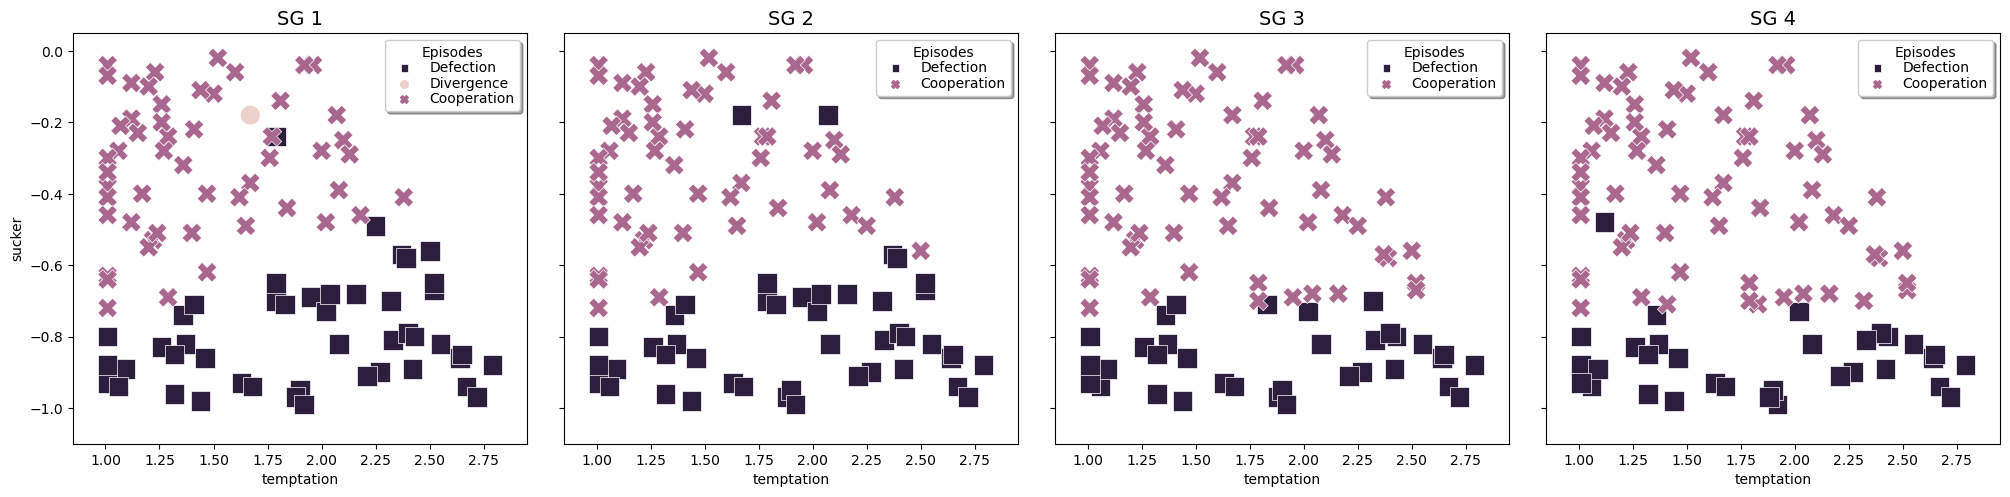

In [22]:
df_episodic_plot = df_episodic_SG_1.copy()
df_episodic_plot.loc[df_episodic_plot[['agent1_strategy','agent1_reward']].isna().any(axis=1), 'agent1_final_strategy'] = -1
df_episodic_plot.loc[df_episodic_plot[['agent2_strategy','agent2_reward']].isna().any(axis=1), 'agent2_final_strategy'] = -1

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

sns.scatterplot(ax=axes[0], data=df_episodic_plot.loc[df_episodic_plot.thresh==0].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[1], data=df_episodic_plot.loc[df_episodic_plot.thresh==1].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[1].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[2], data=df_episodic_plot.loc[df_episodic_plot.thresh==2].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[2].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]

sns.scatterplot(ax=axes[3], data=df_episodic_plot.loc[df_episodic_plot.thresh==3].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[3].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
axes[0].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[1].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[2].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[3].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[0].set_title('SG 1', fontsize=14)
axes[1].set_title('SG 2', fontsize=14)
axes[2].set_title('SG 3', fontsize=14)
axes[3].set_title('SG 4', fontsize=14)
# fig.savefig('images/2_agent_SG_strategy.png', dpi=fig.dpi)


In [14]:
df_normal_SG = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                   'agent2_strategy', 'agent2_reward', 
                                   'temptation', 'reward', 'punishment', 'sucker', 
                                   'agent1_final_strategy', 'agent1_defection_ratio',
                                   'agent2_final_strategy', 'agent2_defection_ratio',
                                   'agent1_updating_times', 'agent2_updating_times', 'thresh'])
for thr in [0,1,2,3]:
    for idx, val in tqdm(enumerate(reward)):
        config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
        config['epsilon_decay'] = 0.995
        config_obj = Config(config)
        with HiddenPrints():
            env = StochasticGameEnvironment(config_obj, thresh=thr)
            agent1 = construct_agent('LSTMQN', config_obj)
            agent2 = construct_agent('LSTMQN', config_obj)
            agents = {}
            agents[0], agents[1] = agent1, agent2 
            count = 0
            convergent_episode_dict = {'strategy':{}, 'reward':{}}

            while True:
                last_reward = {}
                for n in agents:
                    last_reward[n] = agents[n].running_score

                with HiddenPrints():
                    env.play(agent1, agent2, k)

                strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
                count += 1
                update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
                update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)

                print(convergent_episode_dict)

                if count*k >= config_obj.n_episodes:
                    break

                converge = []
                for key, _ in convergent_episode_dict.items():
                    converge.append(len(convergent_episode_dict[key]) == len(agents))
                if sum(converge) >= 2:
                    break
        for key, v in convergent_episode_dict.items():
            if 0 not in list(v.keys()):
                convergent_episode_dict[key][0] = np.nan
            if 1 not in list(v.keys()):
                convergent_episode_dict[key][1] = np.nan    

        df_normal_SG.loc[len(df_normal_SG.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                                convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                                config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                                round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                                float(torch.sum(agent1.own_memory)/agent1.play_times),
                                                round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                                float(torch.sum(agent2.own_memory)/agent2.play_times),
                                                np.nan, np.nan, thr]

100it [1:00:56, 36.56s/it]
100it [52:04, 31.24s/it]
100it [48:11, 28.91s/it]
100it [47:40, 28.61s/it]


In [15]:
df_alter_SG = pd.DataFrame(columns=['agent1_strategy', 'agent1_reward', 
                                  'agent2_strategy', 'agent2_reward', 
                                  'temptation', 'reward', 'punishment', 'sucker', 
                                  'agent1_final_strategy', 'agent1_defection_ratio',
                                  'agent2_final_strategy', 'agent2_defection_ratio',
                                    'agent1_updating_times', 'agent2_updating_times', 'thresh'])
for thr in [0,1,2,3]:
    for idx, val in tqdm(enumerate(reward)):
        config['reward'], config['sucker'], config['temptation'], config['punishment'] = val, sucker[idx], temptation[idx], punishment[idx]
        config_obj = Config(config)
        with HiddenPrints():
            env = StochasticGameEnvironment(config_obj, thresh=thr)
            agent1 = construct_agent('LSTMQN', config_obj)
            agent2 = construct_agent('LSTMQN', config_obj)
            agents = {}
            agents[0], agents[1] = agent1, agent2 
            count = 0
            convergent_episode_dict = {'strategy':{}, 'reward':{}}

            while True:
                last_reward = {}
                for n in agents:
                    last_reward[n] = agents[n].running_score

                TwoAgentSimulation.two_agent_alter_learning(agent1, agent2, config_obj, env, k)

                strategy_convergent_episode, reward_convergent_episode = check_convergence(agents, thresh, k, last_reward)
                count += 1
                update_convergence_episode(convergent_episode_dict, 'strategy', strategy_convergent_episode)
                update_convergence_episode(convergent_episode_dict, 'reward', reward_convergent_episode)

                print(convergent_episode_dict)

                if count*k >= config_obj.n_episodes:
                    break

                converge = []
                for key, _ in convergent_episode_dict.items():
                    converge.append(len(convergent_episode_dict[key]) == len(agents))
                if sum(converge) >= 2:
                    break
        for key, v in convergent_episode_dict.items():
            if 0 not in list(v.keys()):
                convergent_episode_dict[key][0] = np.nan
            if 1 not in list(v.keys()):
                convergent_episode_dict[key][1] = np.nan    


        df_alter_SG.loc[len(df_alter_SG.index)]=[convergent_episode_dict['strategy'][0], convergent_episode_dict['reward'][0], 
                                               convergent_episode_dict['strategy'][1], convergent_episode_dict['reward'][1], 
                                               config['temptation'], config['reward'], config['punishment'], config['sucker'], 
                                               round(float(torch.sum(agent1.own_memory[agent1.play_times-100:agent1.play_times])/100)),
                                               float(torch.sum(agent1.own_memory)/agent1.play_times),
                                               round(float(torch.sum(agent2.own_memory[agent2.play_times-100:agent2.play_times])/100)),
                                               float(torch.sum(agent2.own_memory)/agent2.play_times), 
                                                 np.nan, np.nan, thr]

100it [34:32, 20.73s/it]
100it [36:45, 22.05s/it]
100it [35:51, 21.51s/it]
100it [37:13, 22.34s/it]


In [33]:
df_normal_SG['agent1_updating_times'] = df_normal_SG[['agent1_strategy','agent1_reward']].max(axis=1) - config['batch_size']
df_normal_SG['agent2_updating_times'] = df_normal_SG[['agent2_strategy','agent2_reward']].max(axis=1) - config['batch_size']
df_alter_SG['agent1_updating_times'] = (df_alter_SG[['agent1_strategy','agent1_reward']].max(axis=1))/4
df_alter_SG['agent2_updating_times'] = (df_alter_SG[['agent2_strategy','agent2_reward']].max(axis=1))/4
df_normal_SG['model'] = 'normal'
df_alter_SG['model'] = 'alternative'
df_episodic_SG['model'] = 'episodic'
df_SG = pd.concat([df_normal_SG, df_alter_SG],ignore_index=True)
df_SG = pd.concat([df_SG, df_episodic_SG],ignore_index=True)
df_SG['settlement_prob'] = 0.02
df_episodic_SG_1['model'] = 'episodic'
df_episodic_SG_1['settlement_prob'] = 0.015
df_SG = pd.concat([df_SG, df_episodic_SG_1],ignore_index=True)
df_SG.to_csv('2_agent_SG_all_2.csv',index=False)

In [24]:
df_SG[df_SG.isna().any(axis=1)]

,agent1_strategy,agent1_reward,agent2_strategy,agent2_reward,temptation,reward,punishment,sucker,agent1_final_strategy,agent1_defection_ratio,agent2_final_strategy,agent2_defection_ratio,agent1_updating_times,agent2_updating_times,thresh,model
12,30000.0,NaN,30000.0,NaN,2.07,1.0,0.0,-0.18,-1.0,0.656800,-1.0,0.595433,29936.0,29936.0,0.0,normal
34,26000.0,NaN,26000.0,NaN,1.96,1.0,0.0,-0.04,-1.0,0.472433,-1.0,0.593567,25936.0,25936.0,0.0,normal
611,NaN,NaN,NaN,30000.0,1.01,1.0,0.0,-0.04,-1.0,0.896800,-1.0,0.876300,NaN,7500.0,2.0,alternative
1130,22504.0,NaN,NaN,NaN,1.47,1.0,0.0,-0.40,-1.0,0.883011,-1.0,0.860854,3020.0,3020.0,3.0,episodic


In [35]:
df_SG.loc[df_SG[['agent1_strategy','agent1_reward']].isna().any(axis=1), 'agent1_final_strategy'] = -1
df_SG.loc[df_SG[['agent2_strategy','agent2_reward']].isna().any(axis=1), 'agent2_final_strategy'] = -1
df_episodic_plot = df_SG.loc[df_SG.model=='episodic'].loc[df_SG.settlement_prob==0.02]
df_normal_plot = df_SG.loc[df_SG.model=='normal']
df_alter_plot = df_SG.loc[df_SG.model=='alternative']

Text(0.5, 1.0, 'SG 4')

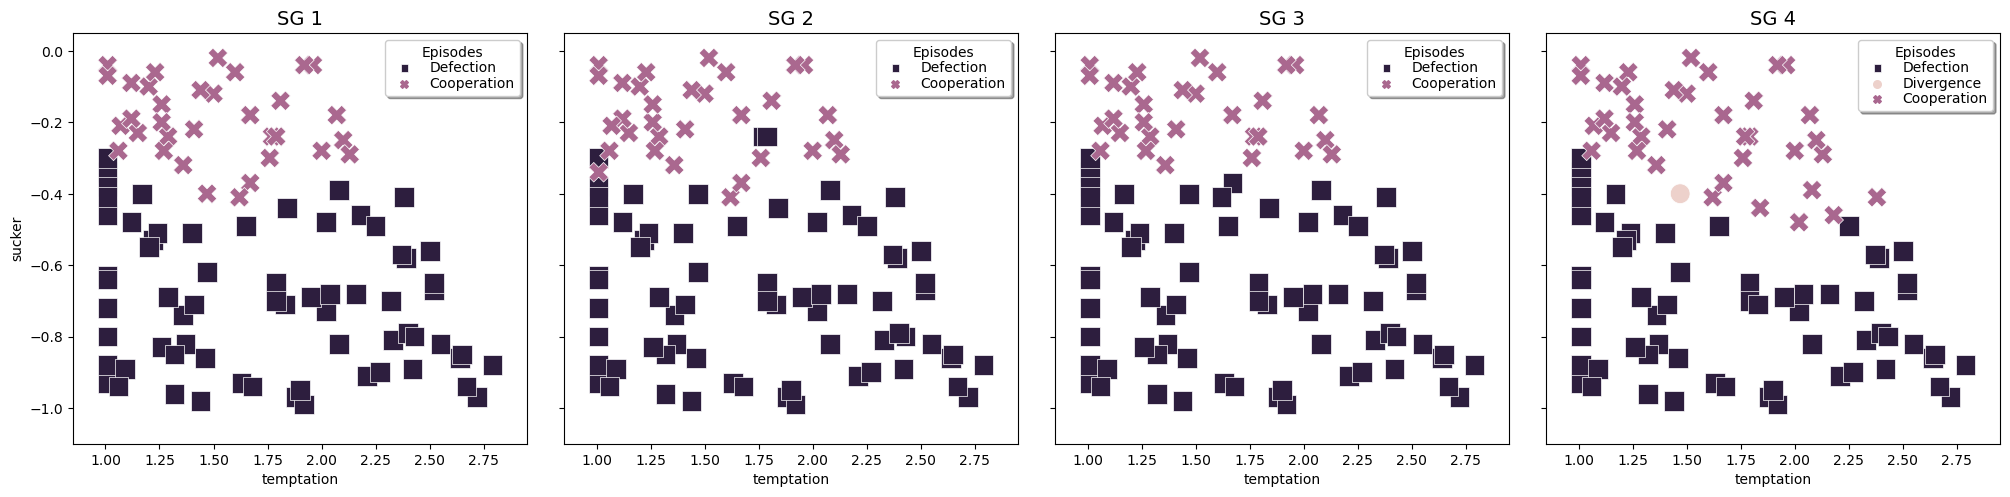

In [26]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

sns.scatterplot(ax=axes[0], data=df_episodic_plot.loc[df_episodic_plot.thresh==0].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[1], data=df_episodic_plot.loc[df_episodic_plot.thresh==1].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[1].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[2], data=df_episodic_plot.loc[df_episodic_plot.thresh==2].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[2].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]

sns.scatterplot(ax=axes[3], data=df_episodic_plot.loc[df_episodic_plot.thresh==3].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[3].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
axes[0].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[1].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[2].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[3].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[0].set_title('SG 1', fontsize=14)
axes[1].set_title('SG 2', fontsize=14)
axes[2].set_title('SG 3', fontsize=14)
axes[3].set_title('SG 4', fontsize=14)
# fig.savefig('images/2_agent_SG_strategy.png', dpi=fig.dpi)


Text(0.5, 1.0, 'SG 4')

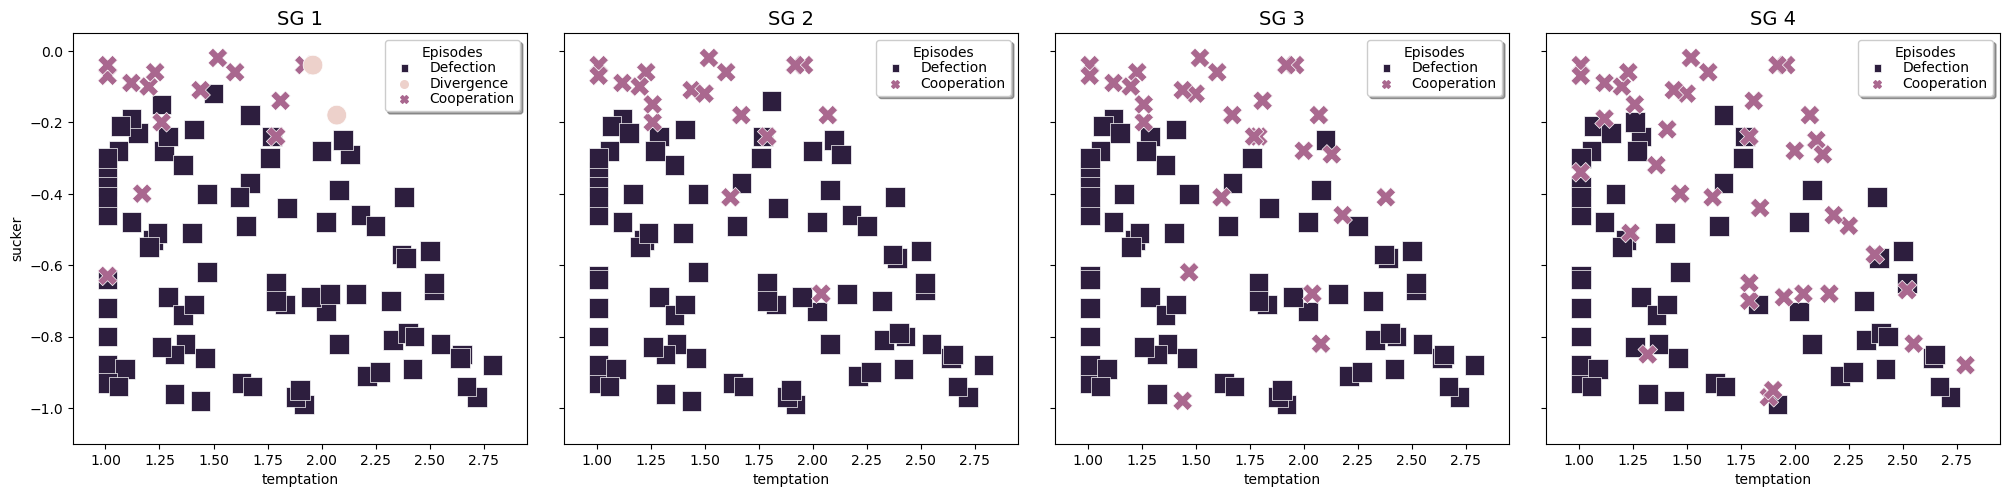

In [29]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

sns.scatterplot(ax=axes[0], data=df_normal_plot.loc[df_normal_plot.thresh==0].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[1], data=df_normal_plot.loc[df_normal_plot.thresh==1].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[1].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[2], data=df_normal_plot.loc[df_normal_plot.thresh==2].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[2].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]

sns.scatterplot(ax=axes[3], data=df_normal_plot.loc[df_normal_plot.thresh==3].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[3].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
axes[0].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[1].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[2].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[3].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[0].set_title('SG 1', fontsize=14)
axes[1].set_title('SG 2', fontsize=14)
axes[2].set_title('SG 3', fontsize=14)
axes[3].set_title('SG 4', fontsize=14)
# fig.savefig('images/2_agent_SG_strategy.png', dpi=fig.dpi)


Text(0.5, 1.0, 'SG 4')

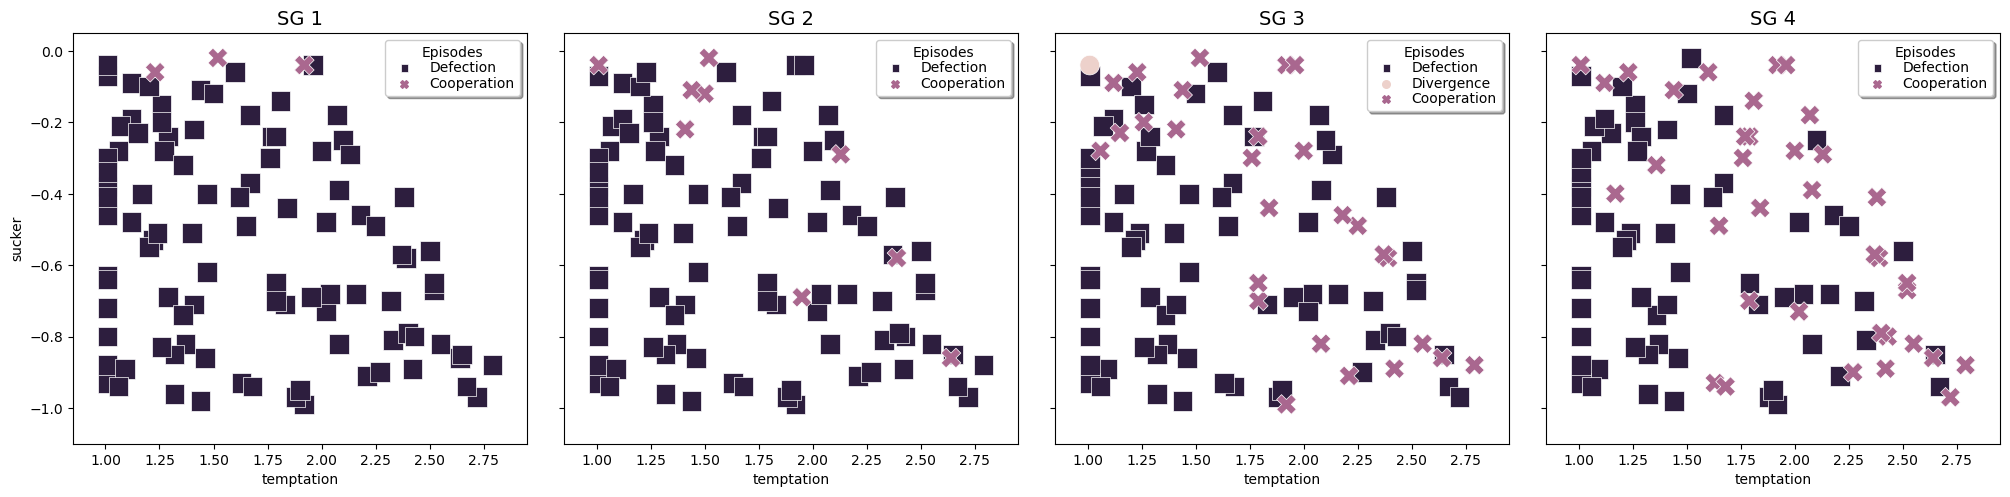

In [32]:
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

sns.scatterplot(ax=axes[0], data=df_alter_plot.loc[df_alter_plot.thresh==0].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[0].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[1], data=df_alter_plot.loc[df_alter_plot.thresh==1].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[1].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
sns.scatterplot(ax=axes[2], data=df_alter_plot.loc[df_alter_plot.thresh==2].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200,200], style='agent1_final_strategy', 
                markers=['o','X','s'], linewidth=0.5, alpha=1)
lgnd = axes[2].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Divergence','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]

sns.scatterplot(ax=axes[3], data=df_alter_plot.loc[df_alter_plot.thresh==3].sort_values(by=['agent1_final_strategy'],ascending=False), y='sucker', x='temptation', 
                hue="agent1_final_strategy", size="agent1_final_strategy", sizes=[200,200], style='agent1_final_strategy', 
                markers=['X','s'], linewidth=0.5, alpha=1, palette='ch:s=0,light=.5')
lgnd = axes[3].legend(scatterpoints=1, frameon=True, labelspacing=.1, title='Episodes', markerscale=.4, 
           labels=['Defection','Cooperation'], loc='upper right', shadow=True)
for i in lgnd.legendHandles:
    i._sizes = [30]
    
axes[0].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[1].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[2].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[3].axis(xmin=0.85,xmax=2.95,ymin=-1.1,ymax=0.05)
axes[0].set_title('SG 1', fontsize=14)
axes[1].set_title('SG 2', fontsize=14)
axes[2].set_title('SG 3', fontsize=14)
axes[3].set_title('SG 4', fontsize=14)
# fig.savefig('images/2_agent_SG_strategy.png', dpi=fig.dpi)
